# Qubit chain puched by measurements

## Introduction

Here we analyze a chain of N-spins where the end-most spins (spin 1 and spin N) are subject to periodic measurements. First we define the Hamiltonian of the chain, then we implement the simulation explicitly.

<div style="text-align: center;">
    <img src="Cimatec.png" alt="Description" style="width: 50%;"/>
    <p style="text-align: center;"><strong>Figure 1:</strong> Example circuit for our monitoring process.</p>
</div>

## Simulation

### Hamiltonians

#### Initial model

The Hamiltonian of a Heisenberg model is given by
\begin{equation}
    H_{Heisenberg} = - \frac{1}{2} \sum_{j=1}^{N-1} \Big( J_x^j X_j X_{j+1} + J_y^j Y_j Y_{j+1} + J_z^j Z_j Z_{j+1} \Big)
\end{equation}
where a term $-h \sum_{j=1}^N Z_j$ can be added in the presence of a magnetic field along the z-axis. However, we leave this case for a later moment.

#### Simplification

Since we are interested in measuring spins 1 and N, let us isolate the terms corresponding to them explicitly:
\begin{equation}
\begin{split}
    H_{Heisenberg} &= - \frac{1}{2} \Big( J_x^1 X_1 X_2 + J_y^1 Y_1 Y_2 + J_z^1 Z_1 Z_2 \Big) - \frac{1}{2} \sum_{j=2}^{N-2} \Big( J_x^j X_j X_{j+1} + J_y^j Y_j Y_{j+1} + J_z^j Z_j Z_{j+1} \Big) -\\
    &- \frac{1}{2} \Big( J_x^{N-1} X_{N-1} X_N + J_y^{N-1} Y_{N-1} Y_N + J_z^{N-1} Z_{N-1} Z_N \Big)
\end{split}
\end{equation}

Now we simplify our initial analysis by considering that the intermediate spins obey the Ising model, i.e. $J_j^x = J_j^y = 0$. Moreover, we also set $J_1^z = J_1^y = 0$ and $J_{N-1}^x = J_{N-1}^y = 0$. This means that spin 1 can only be aligned to the x-axis and all other spins to the z-axis. Thus, incorporating the factor of 1/2 into the coupling constants and setting $J_z^j = J_z$ and $J_x^1 = J_x$, we reach at
\begin{equation}
    H_{open} = - J_x X_1 X_2 - J_z \sum_{j=2}^{N-2} Z_j Z_{j+1} - J_z Z_{N-1} Z_N
\end{equation}
where the subscript _open_ means that we restrict our analysis for now to an _open chain_, i.e. a chain where qubits N and 1 do not interact.

### Defining parameters

In [1]:
# Simulation parameters
num_spins = 5
J_x = 1
J_z = 1

### Visualizing chain

In qiskit the chains are implemented as `CouplingMap` instances, based on the importance of these systems to build the architecture of quantum processors. The idea is to represent our chains as computer science _graphs_, where each qubit is a vertex and each edge connecting two vertices is an interaction.

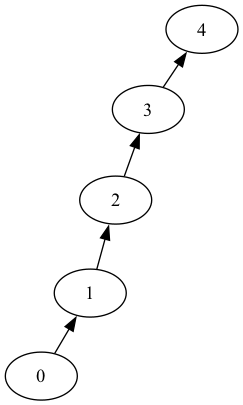

In [14]:
from qiskit.transpiler import CouplingMap

# Creating open chain
chain = CouplingMap.from_line(num_qubits=num_spins, bidirectional=False)
chain.draw()

### Implementing Hamiltonian

Here we implement the Hamiltonians defined above explicitly. In order to optimize its execution on a real hardware we first separate the terms that correspond to even and odd edges of the graphs (edge 0 connects qubits 0 and 1, edge 1 connects qubits 1 and 2, etc.). (In our case, the order of storing the terms into a list matters for implementing the trotterization method during time-evolution.)

In [3]:
from qiskit.quantum_info import SparsePauliOp

# Listing edges
edges = chain.graph.edge_list()
even_edges = [ element for index, element in enumerate(edges) if index % 2 == 0 ]
odd_edges = [ element for index, element in enumerate(edges) if index % 2 == 1 ]

# Building Hamiltonian
ham_list = []

ham_list.append(('XX', even_edges[0], -J_x))

for edge in even_edges[1:]:
    ham_list.append(('ZZ', edge, -J_z))

for edge in odd_edges:
    ham_list.append(('ZZ', edge, -J_z))
    
hamiltonian = SparsePauliOp.from_sparse_list(obj=ham_list, num_qubits=num_spins)

print(hamiltonian)

SparsePauliOp(['IIIXX', 'IZZII', 'IIZZI', 'ZZIII'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j])


#### Energy-flow across the chain

In this project we would like to analyse the flow of energy across the chain. Thus, it is convenient to define a list with each term of the Hamiltonian (which corresponds to an interaction between a given pair of qubits) as a unique `PauliSparseOp`.

In [15]:
# Local terms of the Hamiltonian
ham_terms = []

ham_terms.append(SparsePauliOp.from_sparse_list(obj=[('XX', edges[0], -J_x)], num_qubits=num_spins))

for edge in edges[1:]:
    ham_terms.append(SparsePauliOp.from_sparse_list(obj=[('ZZ', edge, -J_z)], num_qubits=num_spins))

ham_terms

[SparsePauliOp(['IIIXX'],
               coeffs=[-1.+0.j]),
 SparsePauliOp(['IIZZI'],
               coeffs=[-1.+0.j]),
 SparsePauliOp(['IZZII'],
               coeffs=[-1.+0.j]),
 SparsePauliOp(['ZZIII'],
               coeffs=[-1.+0.j])]

### Implementing time-evolution

#### Trotterization

Now we need to represent the time-evolution operator of our chains, $U = e^{-i H \delta t}$, as a quantum circuit. This can be done by getting the matrix form of the Hamiltonian of each system and exponentiating them to define both $U$'s as gates acting on $N$ qubits directly. However, this method is not scallabe, and can become impractical for execution when $N$ is large. This is why we must use _trotterization_ to approximate $U$ efficiently.

In [5]:
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter

# Time-evolution parameter
dt = Parameter('ẟt')

# Number of trotterization layers
trotter_factory = LieTrotter(reps=4)

# Time-evolution operator
U = PauliEvolutionGate(hamiltonian, time=dt)
U_qc = trotter_factory.synthesize(U)

#### Drawing time-evolution circuit

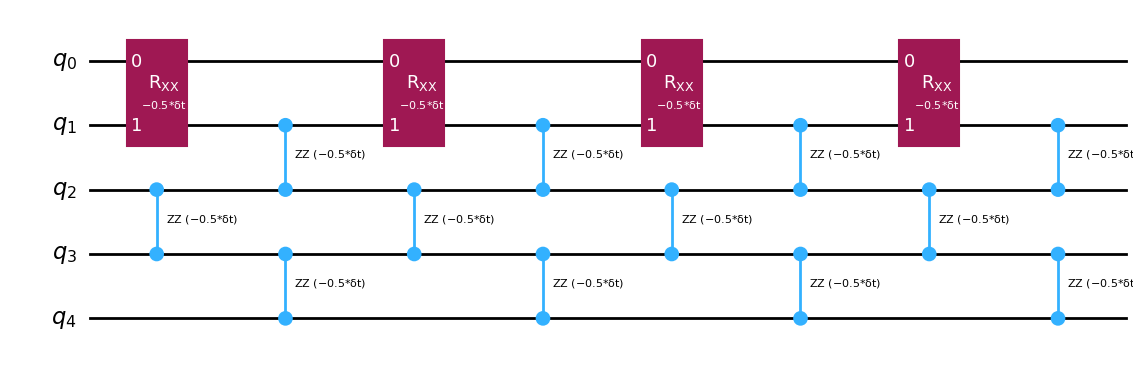

In [6]:
# Time-evolution circuit for an open chain
U_qc.decompose().draw('mpl')

### Implementing simulation

Below we start by creating a dictionary to prepare our circuits for each chain, as exemplified in Fig. 1. Calling a _step_ the compund process of a time-evolution followed by a measurement, we prepare now a circuit containing no steps, a circuit containing 1 step, a circuit containing 2 steps, and so on. Then we transpile these circuits, as well as the Hamiltonian, to a target backend of our choice.

#### Preparing circuits

In this notebook we measure spin 1 with a frequency $f$ and spin N with a frequency $f' = 2f$. For example, we evolve the circuit once, then measure spin N; then we evolve the circuit one more time and measure spin 1 and spin N; then we evolve the circuit one more time and measure only spin N again, and so on.

In [7]:
import numpy as np
from qiskit.circuit import QuantumCircuit
# from qiskit_ibm_runtime.fake_provider import FakeKyoto
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Calling backend and pass manager
backend = AerSimulator()
pass_manager = generate_preset_pass_manager(optimization_level=2, backend=backend)

# Parameters for the simulation
time_step = 0.5/2
num_steps = 15

# Storing circuits to be executed
staged_circuits = {}

# Initial circuit
qc = QuantumCircuit(num_spins, 2)
staged_circuits['step 0'] = qc

# Steps (Varying the measurement frequency for each end-tip qubit)
for step in range(num_steps):
    qc = qc.compose(U_qc)
    qc.measure(num_spins-1, 1)
    qc = qc.compose(U_qc)
    qc.measure([0, num_spins-1], [0, 1])
    
    staged_circuits['step {}'.format(step+1)] = qc

# Transpiling circuits
isa_circuits = {}
for key in staged_circuits.keys():
    isa_circuits[key] = pass_manager.run(staged_circuits[key])

# Transpiling observables
isa_observables = {}
for key in isa_circuits.keys():
    isa_observables[key] = [ h.apply_layout(isa_circuits[key].layout) for h in ham_terms ]

# Setting PUBs
chain_pubs = {'step 0': (isa_circuits['step 0'], isa_observables['step 0'])}
for step in range(1, num_steps+1):
    chain_pubs[f'step {step}'] = ( isa_circuits[f'step {step}'], isa_observables[f'step {step}'], time_step )

#### Simulation

In [8]:
from tqdm import tqdm
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Number of trajectories
num_trajectories = 30

# Calling Estimator
estimator = Estimator(mode=backend)

# Collecting all pubs into a list
all_steps_pubs = []
for key in chain_pubs.keys():
    all_steps_pubs.append(chain_pubs[key])

# Dictionary to store parameters
parameters_dict = {'num_spins': num_spins, 
                   'num_steps': num_steps,
                   'num_trajectories': num_trajectories,
                   'backend': backend.name,
                   'time_step': time_step}

# Dictionary to store expectation values
expvals_dict = { key: np.zeros(len(edges)) for key in chain_pubs.keys() }

for trajectory in tqdm(range(num_trajectories), desc='Trajectory'):
    job = estimator.run(pubs=all_steps_pubs)
    job_result = job.result()
    for i in range(num_steps+1):
        expvals = job_result[i].data.evs
        expvals_dict[f'step {i}'] += (1/num_trajectories)*np.array(expvals)

Trajectory: 100%|███████████████████████████████| 30/30 [01:17<00:00,  2.58s/it]


#### Saving results into a file

In [11]:
# Saving parameters and results into a dictionary
results_dict = { 'Parameters': parameters_dict, 'Expectation values': expvals_dict }

# Converting expectation value array into lists
for key in results_dict['Expectation values'].keys():
    results_dict['Expectation values'][key] = list(results_dict['Expectation values'][key])

In [13]:
import json

# Saving data
filename = f'{num_spins}_spins-{num_steps}_steps-{num_trajectories}_trajectories-dt={time_step}.json'
with open(filename, 'w') as file:
    json.dump(results_dict, file)
    
# Code to load data from a json file
# import json

# with open('data.json', 'r') as file:
#     loaded_dict = json.load(file)